In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import json
import cv2
import os

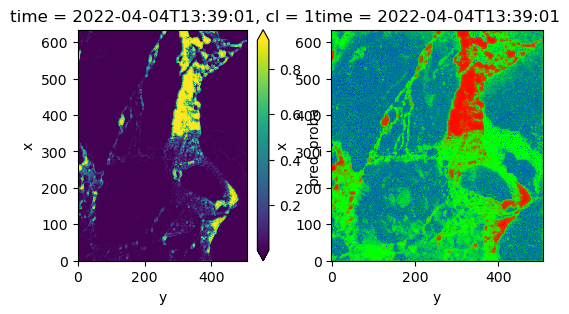

In [2]:
ds_raw = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/predicted/pushbroom/v_0.2/2022-04-04T13:19:30_2022-04-04T13:40:00.nc', engine='h5netcdf')

fig, ax = plt.subplots(1, 2, figsize=(6, 3))


ds_raw.isel(time=-60).pred_proba.plot.imshow(robust=True)

test_im = ds_raw.isel(time=-60).pred_proba.values

ds_raw.isel(time=-60, cl=0).pred_proba.plot.imshow(robust=True, ax=ax[0])

In [4]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
print(f"Using device: {DEVICE}")

sam = sam_model_registry[MODEL_TYPE](checkpoint='/home/jomueller/sam_vit_h_4b8939.pth')
sam.to(device=DEVICE)

/home/jomueller/micromamba/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [5]:
import cv2
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread('sam_test/test.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

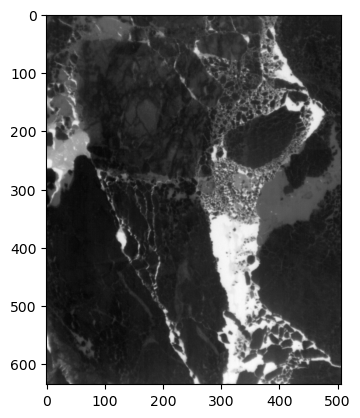

In [7]:
import numpy as np
test_skint = ds_raw.isel(time=-60, cl=0).BT_1.values
test_skint
### first make the grayscale image to a 3 channel image with cv2, normalize it and then convert it to a tensor
### min-max normalize the image

test_skint = (test_skint - test_skint.min()) / (test_skint.max() - test_skint.min())

image_rgb = np.stack([test_skint, test_skint, test_skint], axis=-1)

plt.imshow(image_rgb)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#result = mask_generator.generate(image_rgb)

In [8]:
import numpy as np
seg_map = np.zeros_like(result[0]['segmentation'].astype('float'))
c = 1

for res in result:
    seg_map += res['segmentation'].astype('float') * c
    c += 1
    print(res['predicted_iou'], res['stability_score'])

0.9940928816795349 0.9625602960586548
0.99258953332901 0.9817784428596497
0.9802050590515137 0.9502432346343994
0.9790905117988586 0.9779614210128784
0.9781168103218079 0.9779201745986938
0.9777000546455383 0.9605488777160645
0.9765154123306274 0.9655537605285645
0.973610520362854 0.9906322956085205
0.9735264778137207 0.9651715159416199
0.9723404049873352 0.9890109896659851
0.9707925915718079 0.9727891087532043
0.970409631729126 0.9846625924110413
0.9684678316116333 0.9898219108581543
0.9683178067207336 0.9828326106071472
0.9673181772232056 0.987500011920929
0.9657244086265564 0.9750000238418579
0.965596616268158 0.984581470489502
0.9633553624153137 0.9737997055053711
0.9631953835487366 0.9693251252174377
0.9625647068023682 0.9545990824699402
0.9592026472091675 0.972250759601593
0.9577926397323608 0.9637096524238586
0.9576676487922668 0.9960317611694336
0.9552822113037109 0.9830096960067749
0.9547487497329712 0.9689119458198547
0.9537560939788818 0.9871244430541992
0.9533326029777527 0

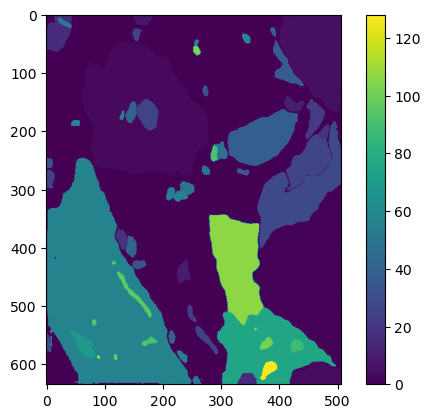

In [9]:
plt.imshow(seg_map)
plt.colorbar()

In [10]:
ds_raw.isel(time=-60).time

<xarray.DataArray 'time' ()> Size: 8B
array('2022-04-04T13:39:01.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-04-04T13:39:01
Attributes:
    long_name:  time

Text(0.5, 1.0, 'Raw prediction')

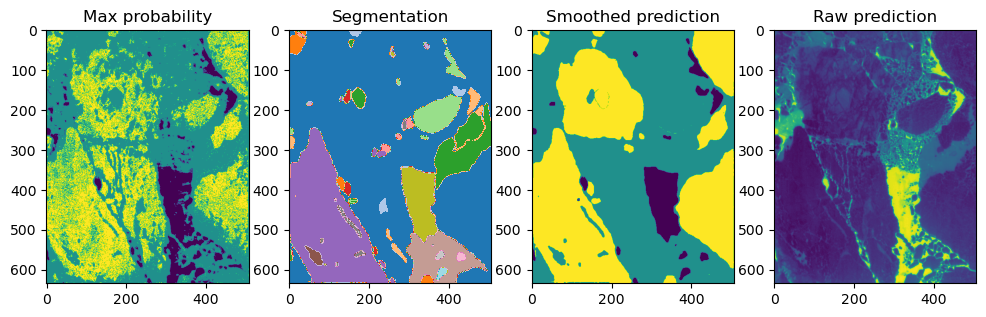

In [13]:
max_proba = test_im.argmax(axis=-1)
smoothed_prediction = np.zeros_like(max_proba)

for seg in np.unique(seg_map):

    uniques, counts = np.unique(max_proba[seg_map == seg], return_counts=True)

    most_occuring_label = uniques[np.argmax(counts)]


    ### assign the class with the most pixels to the segment

    smoothed_prediction[seg_map == seg] = most_occuring_label



### plot all the things

fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].imshow(max_proba)
ax[0].set_title('Max probability')

ax[1].imshow(seg_map, cmap='tab20')
ax[1].set_title('Segmentation')

ax[2].imshow(smoothed_prediction)
ax[2].set_title('Smoothed prediction')

ax[3].imshow(ds_raw.isel(time=-60).BT_1)
ax[3].set_title('Raw prediction')

    

In [ ]:
ds_to_cluster = (ds_raw.isel(time=slice(-200, -1)).pred_proba * 100).astype('uint8')

In [ ]:
ds_to_cluster.to_netcdf('~/to_sc_cluster.nc')

In [ ]:
### make a timing wrapper function 

def timing_wrapper(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution of {func.__name__} took {end - start} seconds")
        return result
    return wrapper



In [ ]:
from helper import concatenate_images

ds_raw_cc1 = concatenate_images(ds_raw.isel(cl=0, time=slice(-5000, -1)), variable='pred_proba')
ds_raw_cc2 = concatenate_images(ds_raw.isel(cl=1, time=slice(-5000, -1)), variable='pred_proba')
ds_raw_cc3 = concatenate_images(ds_raw.isel(cl=2, time=slice(-5000, -1)), variable='pred_proba')
skin_cc = concatenate_images(ds_raw.isel(cl=0, time=slice(-5000, -1)), variable='BT_1')

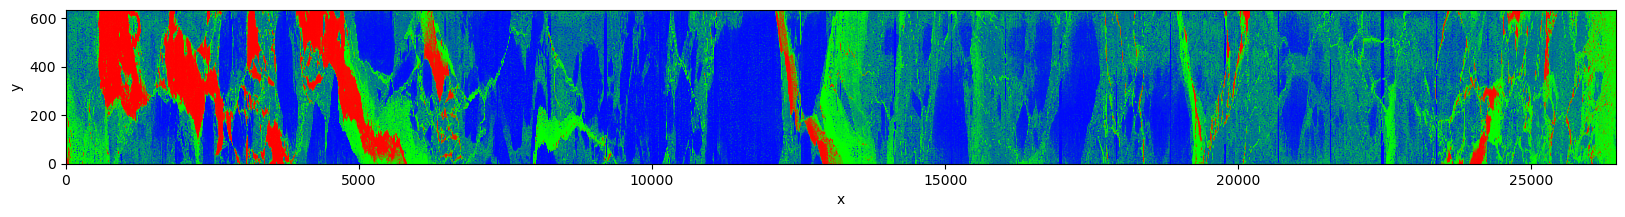

In [ ]:
import numpy as np
ds_to_cluster = xr.Dataset(
    data_vars={
        'cl_0': (['y', 'x'],ds_raw_cc1),
        'cl_1': (['y', 'x'],ds_raw_cc2),
        'cl_2': (['y', 'x'],ds_raw_cc3),
        'skin': (['y', 'x'],skin_cc),
    },
    coords={
        'x' : np.arange(0, ds_raw_cc1.shape[1]),
        'y' : np.arange(0, ds_raw_cc1.shape[0]),
    }
)
fig, ax = plt.subplots(1, 1, figsize=(20, 2))
idx_to_drop = ds_to_cluster.cl_1.mean(dim='y') < 0.01
ds_to_cluster = ds_to_cluster.drop_isel(x=idx_to_drop)

ds_to_cluster[['cl_0', 'cl_1', 'cl_2']].to_array().transpose('y', 'x', 'variable').plot.imshow(robust=True)

In [ ]:
ds_to_cluster.to_netcdf('~/concat_to_sc_cluster.nc', mode='w')

In [ ]:
### find the vertical stripes in the image where cl_1 is 1 across all y

def build_point_grid(nx_per_side: int, ny_pred_side: int) -> np.ndarray:
    
    n_per_side = nx_per_side
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * nx_per_side)
    points_one_side = np.linspace(offset, 1 - offset, nx_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points

build_point_grid(10, 0)
                 
def build_point_grid(nx, ny):
    offset_x = 1 / (2 * nx)
    offset_y = 1 / (2 * nx)
    
    points_x = np.linspace(offset_x, 1-offset_x, nx)
    points_y_= np.linspace(offset_y, 1-offset_y, ny)

    points = np.stack(np.meshgrid(points_x, points_y), axis=-1).reshape(-1, 2)

    return points
    

    



NameError: name 'np' is not defined

In [57]:
sam_path = '/home/jomueller/barat_synced/output_sam'
sam_files = [os.path.join(sam_path, f) for f in os.listdir(sam_path) if f.endswith('.nc')]
sam_files.sort()
sam_files

['/home/jomueller/barat_synced/output_sam/2022-04-04_sam_predict_0_5388.nc',
 '/home/jomueller/barat_synced/output_sam/2022-04-04_sam_predict_10778_16166.nc',
 '/home/jomueller/barat_synced/output_sam/2022-04-04_sam_predict_16167_21555.nc',
 '/home/jomueller/barat_synced/output_sam/2022-04-04_sam_predict_21556_26943.nc',
 '/home/jomueller/barat_synced/output_sam/2022-04-04_sam_predict_5389_10777.nc']

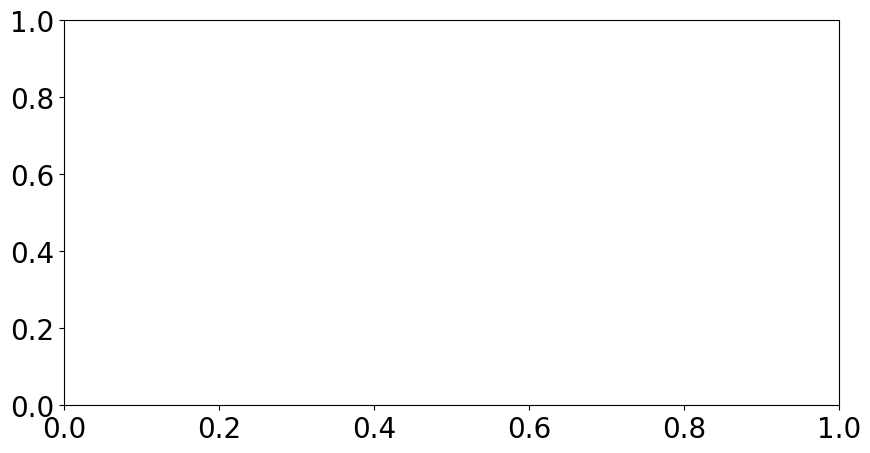

In [60]:
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

In [80]:
ds_sam = xr.open_dataset(sam_files[0])
ds_concat = xr.open_dataset('/home/jomueller/barat_synced/input_sam/2022-04-04_concat.nc')

for file in sam_files:
    ds_sam = xr.open_dataset(file)
    ds_sel = ds_concat.sel(x=ds_sam.x)

    seg_map = ds_sam['segmentation'].values

    max_proba = ds_sam['pred_proba'].argmax(dim='surface_class').values
    smoothed_prediction = np.zeros_like(max_proba)

    for seg in np.unique(seg_map):

        uniques, counts = np.unique(max_proba[seg_map == seg], return_counts=True)

        most_occuring_label = uniques[np.argmax(counts)]


        ### assign the class with the most pixels to the segment

        smoothed_prediction[seg_map == seg] = most_occuring_label
        
    ds_sam['smoothed_prediction'] = xr.DataArray(smoothed_prediction, dims=['y', 'x'])

    fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
    ds_sam.segmentation.plot.imshow(cmap='tab20', ax=ax[2])
    #ds_sam.pred_proba.plot.imshow(robust=True, ax=ax[0])
    ds_sam.smoothed_prediction.plot.imshow(robust=True, ax=ax[1], cmap='viridis', levels=[-.5, .5, 1.5, 2.5], cbar_kwargs={'ticks': [0, 1, 2], 'label': 'Surface class'})
    ds_sel.bt_1.plot(cmap='coolwarm', ax=ax[0], vmin=-30, vmax=0)
    outname = file.split('/')[-1].replace('.nc', 'png')

    for point_coord in ds_sam.point_coords.values:
        x, y = point_coord
        x += ds_sam.x.values[0]
        ax[2].scatter(x, y, color='k', s=10, marker='*')

    plt.savefig(f'../../plots/2022-04-04/{outname}', dpi=480)
    plt.close()

In [91]:
ds_sam = xr.open_dataset(sam_files[3])
ds_sam

<xarray.Dataset> Size: 69MB
Dimensions:          (y: 635, x: 5388, seg: 627, bbox_coords: 4, p_coords: 2,
                      surface_class: 3)
Coordinates:
  * seg              (seg) int64 5kB 0 1 2 3 4 5 6 ... 621 622 623 624 625 626
  * x                (x) int64 43kB 21556 21557 21558 ... 26941 26942 26943
  * y                (y) int64 5kB 0 1 2 3 4 5 6 ... 628 629 630 631 632 633 634
  * bbox_coords      (bbox_coords) int64 32B 0 1 2 3
  * p_coords         (p_coords) int64 16B 0 1
Dimensions without coordinates: surface_class
Data variables:
    segmentation     (y, x) float64 27MB ...
    area             (seg) float64 5kB ...
    bbox             (seg, bbox_coords) float64 20kB ...
    predicted_iou    (seg) float64 5kB ...
    stability_score  (seg) float64 5kB ...
    point_coords     (seg, p_coords) float64 10kB ...
    pred_proba       (surface_class, y, x) float32 41MB ...
Attributes:
    sam_param:points_per_side:                 256
    sam_param:pred_iou_thresh:                 0.86
    sam_param:stability_score_thresh:          0.92
    sam_param:crop_n_layers:                   3
    sam_param:crop_n_points_downscale_factor:  2
    sam_param:min_mask_region_area:            100

In [93]:
seg_map = ds_sam['segmentation'].values

max_proba = ds_sam['pred_proba'].argmax(dim='surface_class').values
smoothed_prediction = np.zeros_like(max_proba)

for seg in np.unique(seg_map):

    uniques, counts = np.unique(max_proba[seg_map == seg], return_counts=True)

    most_occuring_label = uniques[np.argmax(counts)]


    ### assign the class with the most pixels to the segment

    smoothed_prediction[seg_map == seg] = most_occuring_label
    
ds_sam['smoothed_prediction'] = xr.DataArray(smoothed_prediction, dims=['y', 'x'])

(24000.0, 27000.0)

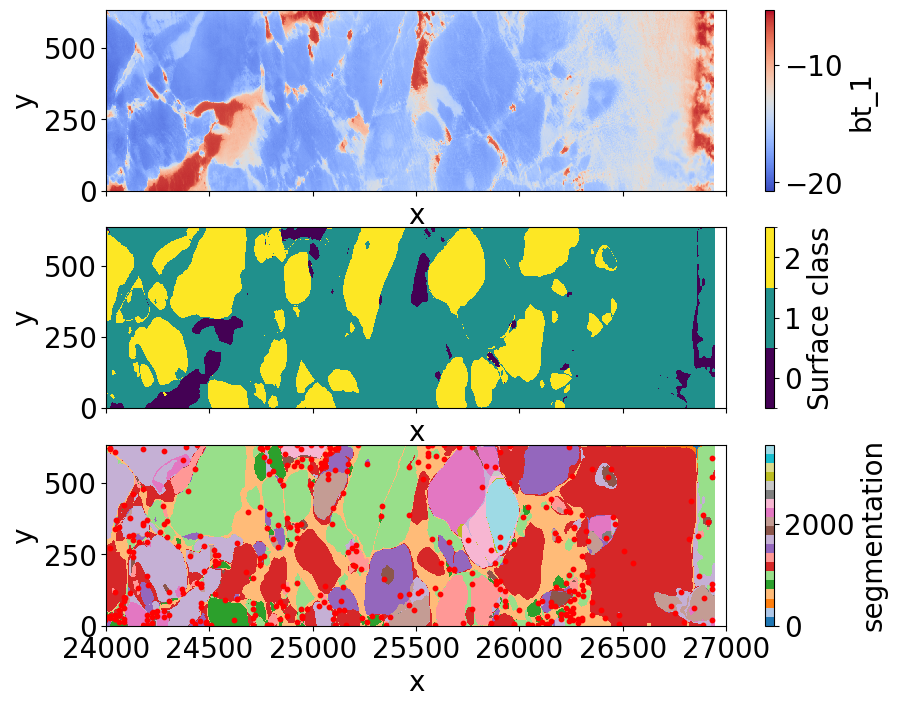

In [97]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
ds_sam.segmentation.plot.imshow(cmap='tab20', ax=ax[2])
#ds_sam.pred_proba.plot.imshow(robust=True, ax=ax[0])

ds_sel = ds_concat.sel(x=ds_sam.x)

im = ds_sam['smoothed_prediction'].plot.imshow(robust=True, ax=ax[1], cmap='viridis', levels=[-.5, .5, 1.5, 2.5], cbar_kwargs={'ticks': [0, 1, 2], 'label': 'Surface class'})

ds_sel.bt_1.plot(cmap='coolwarm', ax=ax[0])



for point_coord in ds_sam.point_coords.values:
    x, y = point_coord
    x += ds_sam.x.values[0]
    ax[2].scatter(x, y, color='r', s=10)

# for bbox in ds_sam.bbox.values:
#     x, y, w, h = bbox
#     print(bbox)
#     rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
#     ax[1].add_patch(rect)

ax[0].set_xlim(24000, 27000)

